<a href="https://colab.research.google.com/github/PhatthanhtuHN/ML_Echocardiographic/blob/main/ML_echocardiographic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn

from torch.utils.data import DataLoader

from torchvision import transforms
import torchvision

import numpy as np
import cv2

from torchsummary import summary

from collections import  namedtuple

import matplotlib.pyplot as plt

from google.colab import drive

from sklearn.metrics import classification_report

In [ ]:
drive.mount('/content/drive')

# Đặt đường dẫn cho thư mục train và test từ dữ liệu Drive đã được kết nối 
train_dir = '/content/drive/MyDrive/Colab Notebooks/DATA_CHAMBER_2021/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/DATA_CHAMBER_2021/test'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Hàm get_classes() trả về ba lớp 2C, 3C, 4C tương ứng với ba loại mặt cắt của ảnh siêu âm tim
def get_classes():
  classes = ['2C', '3C', '4C']
  return classes

TrainTest = namedtuple('TrainTest', ['train', 'test'])
img_size_default = 224
img_size_medium = 64
img_size_small = 32
# Hàm chuẩn bị dữ liệu
def prepare_data(img_size):
  # Hàm transform chuẩn hóa ảnh về kích thước 224 x 224 và chuyển thành Tensor là một mảng nhiều chiều
  transforms_train = transforms.Compose([
    transforms.Resize((img_size, img_size)),  
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]) 
  ])
  transforms_train_augmentation = transforms.Compose([
      transforms.Resize((img_size, img_size)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(degrees=10),
      transforms.ToTensor(), 
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])    
  ])
  transforms_train_preprocess = transforms.Compose([
      transforms.Resize((img_size, img_size)),
      transforms.RandomEqualize(p=0.5),
      transforms.RandomAutocontrast(p=0.5),
      transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 3)),
      transforms.ColorJitter(brightness=[1, 1.5], contrast=[1, 1.5]),
      transforms.ToTensor(), 
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]) 
  ])
  transforms_test = transforms.Compose([
    transforms.Resize((img_size, img_size)), 
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225]) 
  ])
  # Chuẩn bị 2 bộ dữ liệu trainset và testset với đường dẫn như trên, gán nhãn cho ảnh theo tên thư mục và trả về bộ giá trị (tuple) TrainTest gồm hai bộ dữ liệu này
  trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transforms_train)
  # trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transforms_train_augmentation)
  trainset = torchvision.datasets.ImageFolder(root=train_dir, transform=transforms_train_preprocess)
  testset = torchvision.datasets.ImageFolder(root=test_dir, transform=transforms_test)
  print('Number of images in train:', len(trainset), '\nNumber of images in test:', len(testset))
  print('Index of classes:', trainset.class_to_idx)
  print('Type:', type(trainset[0][0]), '| size: ', trainset[0][0].shape)
  return TrainTest(train=trainset, test=testset)

# Hàm đọc bộ dữ liệu, mỗi lần lấy ra 1 batch có độ dài là 32 ảnh đế xử lý song song, nối thành tensor 4 chiều là đầu vào của mạng
def prepare_loader(datasets):
  trainloader = DataLoader(dataset=datasets.train, batch_size=32, shuffle=True, num_workers=4)
  testloader = DataLoader(dataset=datasets.test, batch_size=32, shuffle=False, num_workers=4)
  print('Number of batchs in train:', len(trainloader), '\nNumber of batchs in test:', len(testloader))
  return TrainTest(train=trainloader, test=testloader)

# Dựng mô hình mạng tích chập VGG19
class VGG19(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = self._make_features()
    self.classification_head = nn.Linear(in_features=2048, out_features=3) #7x7x512 với img_size = 224

  def forward(self, x):
    out = self.features(x)
    out = out.view(out.size(0), -1)
    out = self.classification_head(out)
    return out

  def _make_features(self):
    config = [64, 64, 'MP', 128, 128, 'MP', 256, 256, 256, 256, 'MP', 512, 512, 512, 512, 'MP', 512, 512, 512, 512, 'MP']
    layer = []
    c_in = 3
    for c in config:
      if c == 'MP':
        layer += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        layer += [nn.Conv2d(in_channels=c_in, out_channels=c, kernel_size=3, stride=1, padding=1), 
                  nn.BatchNorm2d(num_features=c), 
                  nn.ReLU6(inplace=True)]
        c_in = c
    return nn.Sequential(*layer)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of images in train: 6717 
Number of images in test: 1607
Index of classes: {'2C': 0, '3C': 1, '4C': 2}
Type: <class 'torch.Tensor'> | size:  torch.Size([3, 64, 64])
2C <built-in method size of Tensor object at 0x7efb1a7e94d0>
Number of images in train 6717 Number of images in test 1607


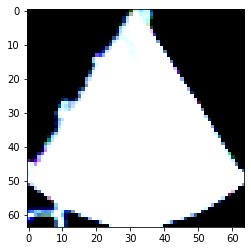

In [ ]:
def imshow(images, labels, predicted, target_names):
  img = torchvision.utils.make_grid(images)
  plt.imshow(img.permute(1, 2, 0).cpu().numpy())
  [print(target_names[c], end=' ') for c in list(labels.cpu().numpy())]
  print()
  [print(target_names[c], end=' ') for c in list(predicted.cpu().numpy())]
  print()
  # print(target_names[list(labels.cpu().numpy())])
  # print(target_names[list(predicted.cpu().numpy())])

  # def imshow(img):
  #   img = img / 2 + 0.5     # unnormalize
  #   npimg = img.numpy()
  #   plt.imshow(np.transpose(npimg, (1, 2, 0)))
  #   plt.show()
def test():
  classes = get_classes()
  datasets = prepare_data(img_size=img_size_medium)

  img, label = datasets.train[0]
  print(classes[label], img.size)
  print('Number of images in train', len(datasets.train), 'Number of images in test', len(datasets.test))
  plt.imshow(img.permute(1, 2, 0))

test()

In [ ]:
# Hàm train với mỗi batch trong bộ dữ liệu
def train_epoch(epoch, model, loader, loss_func, optimizer, device):
  # Cho ảnh (đã được chia thành batch trong loader) lần lượt đi qua model, với mỗi ảnh và nhãn trong bộ dữ liệu là đầu vào của mạng.
  model.train()             
  running_loss = 0.0
  reporting_steps = 30
  for i, (images, labels) in enumerate(loader):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    # print('Type:', type(outputs), '\nOutput shape:', outputs.size())      # Type: <class 'torch.Tensor'> Output shape: torch.Size([32, 3]), với img_size = 224
    loss = loss_func(outputs, labels)

    # Cập nhật tham số trước khi sang step khác
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    # Báo cáo sau reporting_step bước
    if i % reporting_steps == reporting_steps-1:
      print(f'Epoch {epoch} step {i} ave_loss {running_loss/reporting_steps:.4f}')
      running_loss = 0.0

# Hàm test 
def test_epoch(epoch, model, loader, device):
  ytrue =[]
  ypred = []
  # Đặt model ở chế độ đánh giá (evaluate)
  with torch.no_grad():
    model.eval()
    
    # Tính toán đầu ra cho từng ảnh, với nhãn dự đoán dựa trên số to nhất trong outputs
    for i, (images, labels) in enumerate(loader):
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs, dim=1)
      
      ytrue += list(labels.cpu().numpy())
      ypred += list(predicted.cpu().numpy())
      
  return ytrue, ypred   # Trả về nhãn thực, nhãn dự đoán của ảnh


In [ ]:
def main(model_name=None):
  PATH = './' + model_name + '.pth'
  classes = get_classes()
  datasets = prepare_data(img_size=img_size_medium)

  # img, label = datasets.train[0]
  # print(classes[label], img.size)
  # print('Number of images in train', len(datasets.train), 'Number of images in test', len(datasets.test))
  # plt.imshow(img)
  loaders = prepare_loader(datasets)
  # images, labels = iter(loaders.train).next()
  # print(images.shape, labels.shape)

  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  
  if model_name == 'vgg19':
    model = VGG19()
  elif model_name == 'resnet50':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=False)
    model.fc = torch.nn.modules.linear.Linear(in_features=2048, out_features=3, bias=True)
  elif model_name == 'densenet121':
    model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
    model.classifier = torch.nn.modules.linear.Linear(in_features=1024, out_features=3, bias=True)
  else:
    pass
  # summary(model.cuda(), (3, 224, 224))
  # images, labels = iter(loaders.train).next()
  # # print(model)
  # outputs = model(images)
  # print(outputs.shape)
  # print(outputs[0])
  # _, predicted = torch.max(outputs, dim=1)
  # print(predicted)
  # imshow(images, labels, predicted, classes)
  print('Model name: ', model_name)
  model.to(device=device)
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
  for epoch in range(20):
    train_epoch(epoch, model, loaders.train, loss_func, optimizer, device)
    ytrue, ypred = test_epoch(epoch, model, loaders.test, device)
    print(classification_report(ytrue, ypred, target_names=classes))


In [ ]:
allmodels = ['vgg19', 'resnet50', 'densenet121']
for model in allmodels:
  main(model_name=model)


Number of images in train: 6717 
Number of images in test: 1607
Index of classes: {'2C': 0, '3C': 1, '4C': 2}
Type: <class 'torch.Tensor'> | size:  torch.Size([3, 64, 64])
Number of batchs in train: 210 
Number of batchs in test: 51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Model name:  vgg19
Epoch 0 step 29 ave_loss 4.2808
Epoch 0 step 59 ave_loss 3.7988
Epoch 0 step 89 ave_loss 2.3862
Epoch 0 step 119 ave_loss 1.6521
Epoch 0 step 149 ave_loss 1.9296
Epoch 0 step 179 ave_loss 1.5870
Epoch 0 step 209 ave_loss 2.0012
              precision    recall  f1-score   support

          2C       0.20      0.48      0.28       409
          3C       0.22      0.37      0.27       367
          4C       0.00      0.00      0.00       831

    accuracy                           0.20      1607
   macro avg       0.14      0.28      0.18      1607
weighted avg       0.10      0.20      0.13      1607



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.

Epoch 1 step 29 ave_loss 1.5147
Epoch 1 step 59 ave_loss 1.4334
Epoch 1 step 89 ave_loss 1.6121
Epoch 1 step 119 ave_loss 1.8834
Epoch 1 step 149 ave_loss 1.3309
Epoch 1 step 179 ave_loss 1.3528
Epoch 1 step 209 ave_loss 1.3719
              precision    recall  f1-score   support

          2C       0.12      0.03      0.05       409
          3C       0.18      0.47      0.26       367
          4C       0.54      0.35      0.43       831

    accuracy                           0.30      1607
   macro avg       0.28      0.28      0.24      1607
weighted avg       0.35      0.30      0.29      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 step 29 ave_loss 1.3861
Epoch 2 step 59 ave_loss 1.3050
Epoch 2 step 89 ave_loss 1.2906
Epoch 2 step 119 ave_loss 1.4935
Epoch 2 step 149 ave_loss 1.2941
Epoch 2 step 179 ave_loss 1.3740
Epoch 2 step 209 ave_loss 1.1845
              precision    recall  f1-score   support

          2C       0.00      0.00      0.00       409
          3C       0.00      0.00      0.00       367
          4C       0.52      1.00      0.68       831

    accuracy                           0.52      1607
   macro avg       0.17      0.33      0.23      1607
weighted avg       0.27      0.52      0.35      1607



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.

Epoch 3 step 29 ave_loss 1.2334
Epoch 3 step 59 ave_loss 1.2109
Epoch 3 step 89 ave_loss 1.4007
Epoch 3 step 119 ave_loss 1.4691
Epoch 3 step 149 ave_loss 1.3357
Epoch 3 step 179 ave_loss 1.3277
Epoch 3 step 209 ave_loss 1.3655
              precision    recall  f1-score   support

          2C       0.23      0.09      0.13       409
          3C       0.24      0.95      0.38       367
          4C       0.00      0.00      0.00       831

    accuracy                           0.24      1607
   macro avg       0.16      0.35      0.17      1607
weighted avg       0.11      0.24      0.12      1607



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.

Epoch 4 step 29 ave_loss 1.2087
Epoch 4 step 59 ave_loss 1.2961
Epoch 4 step 89 ave_loss 1.2132
Epoch 4 step 119 ave_loss 1.2407
Epoch 4 step 149 ave_loss 1.2114
Epoch 4 step 179 ave_loss 1.2191
Epoch 4 step 209 ave_loss 1.1749
              precision    recall  f1-score   support

          2C       0.13      0.10      0.11       409
          3C       0.27      0.96      0.42       367
          4C       0.00      0.00      0.00       831

    accuracy                           0.24      1607
   macro avg       0.13      0.35      0.18      1607
weighted avg       0.10      0.24      0.12      1607



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.

Epoch 5 step 29 ave_loss 1.1807
Epoch 5 step 59 ave_loss 1.2316
Epoch 5 step 89 ave_loss 1.2424
Epoch 5 step 119 ave_loss 1.2332
Epoch 5 step 149 ave_loss 1.1763
Epoch 5 step 179 ave_loss 1.1418
Epoch 5 step 209 ave_loss 1.1191
              precision    recall  f1-score   support

          2C       0.11      0.07      0.09       409
          3C       0.27      0.83      0.41       367
          4C       0.57      0.15      0.23       831

    accuracy                           0.29      1607
   macro avg       0.32      0.35      0.24      1607
weighted avg       0.39      0.29      0.24      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 step 29 ave_loss 1.1030
Epoch 6 step 59 ave_loss 1.0823
Epoch 6 step 89 ave_loss 1.0845
Epoch 6 step 119 ave_loss 1.0390
Epoch 6 step 149 ave_loss 1.0649
Epoch 6 step 179 ave_loss 1.0493
Epoch 6 step 209 ave_loss 1.0500
              precision    recall  f1-score   support

          2C       0.26      0.40      0.32       409
          3C       0.43      0.47      0.45       367
          4C       0.65      0.46      0.54       831

    accuracy                           0.45      1607
   macro avg       0.45      0.44      0.44      1607
weighted avg       0.50      0.45      0.46      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 step 29 ave_loss 1.0236
Epoch 7 step 59 ave_loss 1.0217
Epoch 7 step 89 ave_loss 1.0286
Epoch 7 step 119 ave_loss 0.9992
Epoch 7 step 149 ave_loss 0.9678
Epoch 7 step 179 ave_loss 0.9253
Epoch 7 step 209 ave_loss 0.9288
              precision    recall  f1-score   support

          2C       0.20      0.32      0.24       409
          3C       0.43      0.72      0.54       367
          4C       0.81      0.32      0.46       831

    accuracy                           0.41      1607
   macro avg       0.48      0.45      0.41      1607
weighted avg       0.57      0.41      0.42      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 step 29 ave_loss 0.8991
Epoch 8 step 59 ave_loss 0.9411
Epoch 8 step 89 ave_loss 0.8191
Epoch 8 step 119 ave_loss 0.7833
Epoch 8 step 149 ave_loss 0.7489
Epoch 8 step 179 ave_loss 0.6654
Epoch 8 step 209 ave_loss 0.6838
              precision    recall  f1-score   support

          2C       0.21      0.23      0.22       409
          3C       0.53      0.65      0.58       367
          4C       0.68      0.57      0.62       831

    accuracy                           0.50      1607
   macro avg       0.47      0.48      0.47      1607
weighted avg       0.52      0.50      0.51      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 step 29 ave_loss 0.6544
Epoch 9 step 59 ave_loss 0.5349
Epoch 9 step 89 ave_loss 0.5613
Epoch 9 step 119 ave_loss 0.5363
Epoch 9 step 149 ave_loss 0.4773
Epoch 9 step 179 ave_loss 0.3933
Epoch 9 step 209 ave_loss 0.4430
              precision    recall  f1-score   support

          2C       0.39      0.52      0.45       409
          3C       0.51      0.85      0.63       367
          4C       0.97      0.52      0.68       831

    accuracy                           0.60      1607
   macro avg       0.62      0.63      0.59      1607
weighted avg       0.72      0.60      0.61      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 step 29 ave_loss 0.3662
Epoch 10 step 59 ave_loss 0.3430
Epoch 10 step 89 ave_loss 0.3219
Epoch 10 step 119 ave_loss 0.3128
Epoch 10 step 149 ave_loss 0.3192
Epoch 10 step 179 ave_loss 0.2806
Epoch 10 step 209 ave_loss 0.3099
              precision    recall  f1-score   support

          2C       0.39      0.58      0.47       409
          3C       0.54      0.77      0.64       367
          4C       1.00      0.58      0.74       831

    accuracy                           0.62      1607
   macro avg       0.65      0.64      0.61      1607
weighted avg       0.74      0.62      0.65      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 step 29 ave_loss 0.2781
Epoch 11 step 59 ave_loss 0.2658
Epoch 11 step 89 ave_loss 0.2164
Epoch 11 step 119 ave_loss 0.3243
Epoch 11 step 149 ave_loss 0.2404
Epoch 11 step 179 ave_loss 0.2094
Epoch 11 step 209 ave_loss 0.2048
              precision    recall  f1-score   support

          2C       0.55      0.86      0.67       409
          3C       0.74      0.83      0.78       367
          4C       1.00      0.68      0.81       831

    accuracy                           0.76      1607
   macro avg       0.76      0.79      0.75      1607
weighted avg       0.83      0.76      0.77      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 step 29 ave_loss 0.1769
Epoch 12 step 59 ave_loss 0.1786
Epoch 12 step 89 ave_loss 0.1969
Epoch 12 step 119 ave_loss 0.2251
Epoch 12 step 149 ave_loss 0.1720
Epoch 12 step 179 ave_loss 0.2053
Epoch 12 step 209 ave_loss 0.1739
              precision    recall  f1-score   support

          2C       0.94      0.48      0.63       409
          3C       0.64      0.96      0.77       367
          4C       0.97      0.99      0.98       831

    accuracy                           0.85      1607
   macro avg       0.85      0.81      0.79      1607
weighted avg       0.89      0.85      0.84      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 step 29 ave_loss 0.2092
Epoch 13 step 59 ave_loss 0.1591
Epoch 13 step 89 ave_loss 0.1435
Epoch 13 step 119 ave_loss 0.1542
Epoch 13 step 149 ave_loss 0.1323
Epoch 13 step 179 ave_loss 0.1766
Epoch 13 step 209 ave_loss 0.1384
              precision    recall  f1-score   support

          2C       0.65      0.67      0.66       409
          3C       0.68      0.92      0.78       367
          4C       0.98      0.82      0.89       831

    accuracy                           0.80      1607
   macro avg       0.77      0.80      0.78      1607
weighted avg       0.83      0.80      0.81      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 step 29 ave_loss 0.1182
Epoch 14 step 59 ave_loss 0.1115
Epoch 14 step 89 ave_loss 0.1431
Epoch 14 step 119 ave_loss 0.1404
Epoch 14 step 149 ave_loss 0.1251
Epoch 14 step 179 ave_loss 0.1494
Epoch 14 step 209 ave_loss 0.1033
              precision    recall  f1-score   support

          2C       0.77      0.78      0.77       409
          3C       0.79      0.91      0.84       367
          4C       0.98      0.91      0.95       831

    accuracy                           0.88      1607
   macro avg       0.85      0.86      0.85      1607
weighted avg       0.88      0.88      0.88      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 step 29 ave_loss 0.1085
Epoch 15 step 59 ave_loss 0.1300
Epoch 15 step 89 ave_loss 0.1361
Epoch 15 step 119 ave_loss 0.1260
Epoch 15 step 149 ave_loss 0.1233
Epoch 15 step 179 ave_loss 0.0866
Epoch 15 step 209 ave_loss 0.0934
              precision    recall  f1-score   support

          2C       0.72      0.65      0.68       409
          3C       0.62      0.85      0.72       367
          4C       0.98      0.87      0.92       831

    accuracy                           0.81      1607
   macro avg       0.77      0.79      0.77      1607
weighted avg       0.83      0.81      0.81      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 step 29 ave_loss 0.0788
Epoch 16 step 59 ave_loss 0.1197
Epoch 16 step 89 ave_loss 0.0937
Epoch 16 step 119 ave_loss 0.0966
Epoch 16 step 149 ave_loss 0.0791
Epoch 16 step 179 ave_loss 0.1081
Epoch 16 step 209 ave_loss 0.0718
              precision    recall  f1-score   support

          2C       0.67      0.90      0.77       409
          3C       0.85      0.75      0.80       367
          4C       1.00      0.88      0.94       831

    accuracy                           0.86      1607
   macro avg       0.84      0.84      0.83      1607
weighted avg       0.88      0.86      0.86      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 step 29 ave_loss 0.0963
Epoch 17 step 59 ave_loss 0.0770
Epoch 17 step 89 ave_loss 0.0899
Epoch 17 step 119 ave_loss 0.0641
Epoch 17 step 149 ave_loss 0.0872
Epoch 17 step 179 ave_loss 0.0906
Epoch 17 step 209 ave_loss 0.0524
              precision    recall  f1-score   support

          2C       0.70      0.74      0.72       409
          3C       0.57      0.90      0.70       367
          4C       1.00      0.72      0.84       831

    accuracy                           0.77      1607
   macro avg       0.76      0.79      0.75      1607
weighted avg       0.83      0.77      0.78      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 step 29 ave_loss 0.0911
Epoch 18 step 59 ave_loss 0.0867
Epoch 18 step 89 ave_loss 0.0634
Epoch 18 step 119 ave_loss 0.0801
Epoch 18 step 149 ave_loss 0.0844
Epoch 18 step 179 ave_loss 0.0956
Epoch 18 step 209 ave_loss 0.0690
              precision    recall  f1-score   support

          2C       0.79      0.83      0.81       409
          3C       0.65      0.82      0.72       367
          4C       1.00      0.86      0.92       831

    accuracy                           0.84      1607
   macro avg       0.81      0.84      0.82      1607
weighted avg       0.87      0.84      0.85      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 step 29 ave_loss 0.0757
Epoch 19 step 59 ave_loss 0.0799
Epoch 19 step 89 ave_loss 0.1007
Epoch 19 step 119 ave_loss 0.0636
Epoch 19 step 149 ave_loss 0.0801
Epoch 19 step 179 ave_loss 0.0773
Epoch 19 step 209 ave_loss 0.0501
              precision    recall  f1-score   support

          2C       0.62      0.82      0.71       409
          3C       0.72      0.81      0.76       367
          4C       1.00      0.78      0.88       831

    accuracy                           0.80      1607
   macro avg       0.78      0.81      0.78      1607
weighted avg       0.84      0.80      0.81      1607

Number of images in train: 6717 
Number of images in test: 1607
Index of classes: {'2C': 0, '3C': 1, '4C': 2}
Type: <class 'torch.Tensor'> | size:  torch.Size([3, 64, 64])
Number of batchs in train: 210 
Number of batchs in test: 51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Model name:  resnet50
Epoch 0 step 29 ave_loss 5.8306
Epoch 0 step 59 ave_loss 3.3096
Epoch 0 step 89 ave_loss 2.4417
Epoch 0 step 119 ave_loss 2.3555
Epoch 0 step 149 ave_loss 1.6005
Epoch 0 step 179 ave_loss 1.3954
Epoch 0 step 209 ave_loss 1.2501
              precision    recall  f1-score   support

          2C       0.00      0.00      0.00       409
          3C       0.31      1.00      0.47       367
          4C       1.00      0.51      0.67       831

    accuracy                           0.49      1607
   macro avg       0.44      0.50      0.38      1607
weighted avg       0.59      0.49      0.46      1607



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.

Epoch 1 step 29 ave_loss 0.9430
Epoch 1 step 59 ave_loss 0.7504
Epoch 1 step 89 ave_loss 0.7538
Epoch 1 step 119 ave_loss 0.5568
Epoch 1 step 149 ave_loss 0.5410
Epoch 1 step 179 ave_loss 0.8440
Epoch 1 step 209 ave_loss 0.5976
              precision    recall  f1-score   support

          2C       0.43      0.79      0.56       409
          3C       0.78      0.86      0.82       367
          4C       1.00      0.54      0.70       831

    accuracy                           0.68      1607
   macro avg       0.74      0.73      0.69      1607
weighted avg       0.80      0.68      0.69      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 step 29 ave_loss 0.5418
Epoch 2 step 59 ave_loss 0.4199
Epoch 2 step 89 ave_loss 0.5983
Epoch 2 step 119 ave_loss 0.4684
Epoch 2 step 149 ave_loss 0.4270
Epoch 2 step 179 ave_loss 0.4782
Epoch 2 step 209 ave_loss 0.4146
              precision    recall  f1-score   support

          2C       0.48      0.88      0.62       409
          3C       0.81      0.71      0.76       367
          4C       1.00      0.64      0.78       831

    accuracy                           0.72      1607
   macro avg       0.76      0.75      0.72      1607
weighted avg       0.82      0.72      0.74      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 step 29 ave_loss 0.3526
Epoch 3 step 59 ave_loss 0.2587
Epoch 3 step 89 ave_loss 0.1863
Epoch 3 step 119 ave_loss 0.2351
Epoch 3 step 149 ave_loss 0.2740
Epoch 3 step 179 ave_loss 0.2071
Epoch 3 step 209 ave_loss 0.2925
              precision    recall  f1-score   support

          2C       0.49      0.69      0.57       409
          3C       0.65      0.85      0.73       367
          4C       0.99      0.65      0.78       831

    accuracy                           0.70      1607
   macro avg       0.71      0.73      0.70      1607
weighted avg       0.78      0.70      0.72      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 step 29 ave_loss 0.2807
Epoch 4 step 59 ave_loss 0.1943
Epoch 4 step 89 ave_loss 0.1633
Epoch 4 step 119 ave_loss 0.1340
Epoch 4 step 149 ave_loss 0.1470
Epoch 4 step 179 ave_loss 0.1471
Epoch 4 step 209 ave_loss 0.1473
              precision    recall  f1-score   support

          2C       0.63      0.90      0.74       409
          3C       0.85      0.78      0.81       367
          4C       1.00      0.82      0.90       831

    accuracy                           0.83      1607
   macro avg       0.82      0.83      0.82      1607
weighted avg       0.87      0.83      0.84      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 step 29 ave_loss 0.2350
Epoch 5 step 59 ave_loss 0.2336
Epoch 5 step 89 ave_loss 0.1691
Epoch 5 step 119 ave_loss 0.1104
Epoch 5 step 149 ave_loss 0.1589
Epoch 5 step 179 ave_loss 0.1156
Epoch 5 step 209 ave_loss 0.0836
              precision    recall  f1-score   support

          2C       0.88      0.87      0.87       409
          3C       0.80      0.92      0.86       367
          4C       1.00      0.94      0.97       831

    accuracy                           0.92      1607
   macro avg       0.89      0.91      0.90      1607
weighted avg       0.92      0.92      0.92      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 step 29 ave_loss 0.0858
Epoch 6 step 59 ave_loss 0.0764
Epoch 6 step 89 ave_loss 0.0786
Epoch 6 step 119 ave_loss 0.0918
Epoch 6 step 149 ave_loss 0.0695
Epoch 6 step 179 ave_loss 0.0636
Epoch 6 step 209 ave_loss 0.0521
              precision    recall  f1-score   support

          2C       0.72      0.75      0.73       409
          3C       0.66      0.86      0.75       367
          4C       1.00      0.85      0.92       831

    accuracy                           0.83      1607
   macro avg       0.79      0.82      0.80      1607
weighted avg       0.85      0.83      0.83      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 step 29 ave_loss 0.0801
Epoch 7 step 59 ave_loss 0.0901
Epoch 7 step 89 ave_loss 0.0929
Epoch 7 step 119 ave_loss 0.0743
Epoch 7 step 149 ave_loss 0.0763
Epoch 7 step 179 ave_loss 0.0432
Epoch 7 step 209 ave_loss 0.0634
              precision    recall  f1-score   support

          2C       0.88      0.59      0.71       409
          3C       0.63      0.95      0.76       367
          4C       0.99      0.93      0.96       831

    accuracy                           0.85      1607
   macro avg       0.84      0.83      0.81      1607
weighted avg       0.88      0.85      0.85      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 step 29 ave_loss 0.0640
Epoch 8 step 59 ave_loss 0.0588
Epoch 8 step 89 ave_loss 0.0388
Epoch 8 step 119 ave_loss 0.0455
Epoch 8 step 149 ave_loss 0.0668
Epoch 8 step 179 ave_loss 0.0532
Epoch 8 step 209 ave_loss 0.0775
              precision    recall  f1-score   support

          2C       0.79      0.65      0.71       409
          3C       0.65      0.96      0.77       367
          4C       1.00      0.88      0.94       831

    accuracy                           0.84      1607
   macro avg       0.81      0.83      0.81      1607
weighted avg       0.87      0.84      0.84      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 step 29 ave_loss 0.0236
Epoch 9 step 59 ave_loss 0.0329
Epoch 9 step 89 ave_loss 0.0538
Epoch 9 step 119 ave_loss 0.0655
Epoch 9 step 149 ave_loss 0.0765
Epoch 9 step 179 ave_loss 0.0263
Epoch 9 step 209 ave_loss 0.0312
              precision    recall  f1-score   support

          2C       0.82      0.84      0.83       409
          3C       0.83      0.92      0.87       367
          4C       0.99      0.93      0.96       831

    accuracy                           0.90      1607
   macro avg       0.88      0.90      0.89      1607
weighted avg       0.91      0.90      0.90      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 step 29 ave_loss 0.0622
Epoch 10 step 59 ave_loss 0.0523
Epoch 10 step 89 ave_loss 0.0433
Epoch 10 step 119 ave_loss 0.0287
Epoch 10 step 149 ave_loss 0.0519
Epoch 10 step 179 ave_loss 0.0412
Epoch 10 step 209 ave_loss 0.0298
              precision    recall  f1-score   support

          2C       0.82      0.82      0.82       409
          3C       0.74      0.92      0.82       367
          4C       1.00      0.89      0.94       831

    accuracy                           0.88      1607
   macro avg       0.85      0.88      0.86      1607
weighted avg       0.89      0.88      0.88      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 step 29 ave_loss 0.0131
Epoch 11 step 59 ave_loss 0.0368
Epoch 11 step 89 ave_loss 0.0424
Epoch 11 step 119 ave_loss 0.0217
Epoch 11 step 149 ave_loss 0.0193
Epoch 11 step 179 ave_loss 0.0166
Epoch 11 step 209 ave_loss 0.0227
              precision    recall  f1-score   support

          2C       0.80      0.79      0.80       409
          3C       0.73      0.90      0.81       367
          4C       1.00      0.90      0.94       831

    accuracy                           0.87      1607
   macro avg       0.84      0.86      0.85      1607
weighted avg       0.89      0.87      0.87      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 step 29 ave_loss 0.0464
Epoch 12 step 59 ave_loss 0.0255
Epoch 12 step 89 ave_loss 0.0290
Epoch 12 step 119 ave_loss 0.0083
Epoch 12 step 149 ave_loss 0.0103
Epoch 12 step 179 ave_loss 0.0228
Epoch 12 step 209 ave_loss 0.0418
              precision    recall  f1-score   support

          2C       0.69      0.65      0.67       409
          3C       0.62      0.96      0.75       367
          4C       1.00      0.79      0.88       831

    accuracy                           0.79      1607
   macro avg       0.77      0.80      0.77      1607
weighted avg       0.83      0.79      0.80      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 step 29 ave_loss 0.0337
Epoch 13 step 59 ave_loss 0.0178
Epoch 13 step 89 ave_loss 0.0147
Epoch 13 step 119 ave_loss 0.0197
Epoch 13 step 149 ave_loss 0.0281
Epoch 13 step 179 ave_loss 0.0304
Epoch 13 step 209 ave_loss 0.0192
              precision    recall  f1-score   support

          2C       0.83      0.89      0.86       409
          3C       0.82      0.88      0.85       367
          4C       1.00      0.93      0.96       831

    accuracy                           0.91      1607
   macro avg       0.88      0.90      0.89      1607
weighted avg       0.91      0.91      0.91      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 step 29 ave_loss 0.0273
Epoch 14 step 59 ave_loss 0.0102
Epoch 14 step 89 ave_loss 0.0285
Epoch 14 step 119 ave_loss 0.0104
Epoch 14 step 149 ave_loss 0.0091
Epoch 14 step 179 ave_loss 0.0311
Epoch 14 step 209 ave_loss 0.0230
              precision    recall  f1-score   support

          2C       0.76      0.72      0.74       409
          3C       0.67      0.93      0.78       367
          4C       1.00      0.86      0.92       831

    accuracy                           0.84      1607
   macro avg       0.81      0.83      0.81      1607
weighted avg       0.86      0.84      0.84      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 step 29 ave_loss 0.0145
Epoch 15 step 59 ave_loss 0.0219
Epoch 15 step 89 ave_loss 0.0323
Epoch 15 step 119 ave_loss 0.0210
Epoch 15 step 149 ave_loss 0.0124
Epoch 15 step 179 ave_loss 0.0120
Epoch 15 step 209 ave_loss 0.0192
              precision    recall  f1-score   support

          2C       0.84      0.74      0.79       409
          3C       0.67      0.92      0.77       367
          4C       1.00      0.89      0.94       831

    accuracy                           0.86      1607
   macro avg       0.84      0.85      0.84      1607
weighted avg       0.88      0.86      0.86      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 step 29 ave_loss 0.0113
Epoch 16 step 59 ave_loss 0.0195
Epoch 16 step 89 ave_loss 0.0250
Epoch 16 step 119 ave_loss 0.0209
Epoch 16 step 149 ave_loss 0.0243
Epoch 16 step 179 ave_loss 0.0276
Epoch 16 step 209 ave_loss 0.0176
              precision    recall  f1-score   support

          2C       0.77      0.84      0.80       409
          3C       0.72      0.89      0.80       367
          4C       1.00      0.85      0.92       831

    accuracy                           0.86      1607
   macro avg       0.83      0.86      0.84      1607
weighted avg       0.88      0.86      0.86      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 step 29 ave_loss 0.0274
Epoch 17 step 59 ave_loss 0.0072
Epoch 17 step 89 ave_loss 0.0235
Epoch 17 step 119 ave_loss 0.0148
Epoch 17 step 149 ave_loss 0.0249
Epoch 17 step 179 ave_loss 0.0060
Epoch 17 step 209 ave_loss 0.0064
              precision    recall  f1-score   support

          2C       0.79      0.84      0.81       409
          3C       0.71      0.89      0.79       367
          4C       1.00      0.85      0.92       831

    accuracy                           0.86      1607
   macro avg       0.83      0.86      0.84      1607
weighted avg       0.88      0.86      0.86      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 step 29 ave_loss 0.0058
Epoch 18 step 59 ave_loss 0.0077
Epoch 18 step 89 ave_loss 0.0055
Epoch 18 step 119 ave_loss 0.0153
Epoch 18 step 149 ave_loss 0.0175
Epoch 18 step 179 ave_loss 0.0085
Epoch 18 step 209 ave_loss 0.0078
              precision    recall  f1-score   support

          2C       0.67      0.91      0.77       409
          3C       0.87      0.89      0.88       367
          4C       1.00      0.81      0.90       831

    accuracy                           0.86      1607
   macro avg       0.85      0.87      0.85      1607
weighted avg       0.89      0.86      0.86      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 step 29 ave_loss 0.0197
Epoch 19 step 59 ave_loss 0.0230
Epoch 19 step 89 ave_loss 0.0054
Epoch 19 step 119 ave_loss 0.0113
Epoch 19 step 149 ave_loss 0.0146
Epoch 19 step 179 ave_loss 0.0107
Epoch 19 step 209 ave_loss 0.0219
              precision    recall  f1-score   support

          2C       0.75      0.77      0.76       409
          3C       0.69      0.88      0.77       367
          4C       1.00      0.86      0.93       831

    accuracy                           0.84      1607
   macro avg       0.81      0.84      0.82      1607
weighted avg       0.86      0.84      0.85      1607

Number of images in train: 6717 
Number of images in test: 1607
Index of classes: {'2C': 0, '3C': 1, '4C': 2}
Type: <class 'torch.Tensor'> | size:  torch.Size([3, 64, 64])
Number of batchs in train: 210 
Number of batchs in test: 51


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Model name:  densenet121
Epoch 0 step 29 ave_loss 1.1397
Epoch 0 step 59 ave_loss 0.9590
Epoch 0 step 89 ave_loss 0.7299
Epoch 0 step 119 ave_loss 0.5516
Epoch 0 step 149 ave_loss 0.4198
Epoch 0 step 179 ave_loss 0.4201
Epoch 0 step 209 ave_loss 0.2951
              precision    recall  f1-score   support

          2C       0.55      0.91      0.68       409
          3C       0.70      0.76      0.73       367
          4C       0.96      0.61      0.74       831

    accuracy                           0.72      1607
   macro avg       0.74      0.76      0.72      1607
weighted avg       0.80      0.72      0.72      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1 step 29 ave_loss 0.2912
Epoch 1 step 59 ave_loss 0.2985
Epoch 1 step 89 ave_loss 0.3033
Epoch 1 step 119 ave_loss 0.2369
Epoch 1 step 149 ave_loss 0.1704
Epoch 1 step 179 ave_loss 0.1795
Epoch 1 step 209 ave_loss 0.1971
              precision    recall  f1-score   support

          2C       0.71      0.93      0.81       409
          3C       0.74      0.85      0.79       367
          4C       1.00      0.78      0.88       831

    accuracy                           0.84      1607
   macro avg       0.82      0.86      0.83      1607
weighted avg       0.87      0.84      0.84      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 2 step 29 ave_loss 0.1454
Epoch 2 step 59 ave_loss 0.1517
Epoch 2 step 89 ave_loss 0.1445
Epoch 2 step 119 ave_loss 0.1910
Epoch 2 step 149 ave_loss 0.1118
Epoch 2 step 179 ave_loss 0.1083
Epoch 2 step 209 ave_loss 0.0842
              precision    recall  f1-score   support

          2C       0.81      0.76      0.78       409
          3C       0.70      0.97      0.81       367
          4C       0.97      0.84      0.90       831

    accuracy                           0.85      1607
   macro avg       0.83      0.86      0.83      1607
weighted avg       0.87      0.85      0.85      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 3 step 29 ave_loss 0.0646
Epoch 3 step 59 ave_loss 0.0652
Epoch 3 step 89 ave_loss 0.0878
Epoch 3 step 119 ave_loss 0.0762
Epoch 3 step 149 ave_loss 0.0956
Epoch 3 step 179 ave_loss 0.1231
Epoch 3 step 209 ave_loss 0.1171
              precision    recall  f1-score   support

          2C       0.77      0.62      0.69       409
          3C       0.65      0.87      0.75       367
          4C       1.00      0.95      0.97       831

    accuracy                           0.85      1607
   macro avg       0.81      0.81      0.80      1607
weighted avg       0.86      0.85      0.85      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 4 step 29 ave_loss 0.0829
Epoch 4 step 59 ave_loss 0.0555
Epoch 4 step 89 ave_loss 0.0996
Epoch 4 step 119 ave_loss 0.0594
Epoch 4 step 149 ave_loss 0.0684
Epoch 4 step 179 ave_loss 0.0779
Epoch 4 step 209 ave_loss 0.0324
              precision    recall  f1-score   support

          2C       0.87      0.89      0.88       409
          3C       0.86      0.88      0.87       367
          4C       0.98      0.97      0.98       831

    accuracy                           0.93      1607
   macro avg       0.91      0.91      0.91      1607
weighted avg       0.93      0.93      0.93      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 5 step 29 ave_loss 0.0517
Epoch 5 step 59 ave_loss 0.0213
Epoch 5 step 89 ave_loss 0.0251
Epoch 5 step 119 ave_loss 0.0319
Epoch 5 step 149 ave_loss 0.0173
Epoch 5 step 179 ave_loss 0.0475
Epoch 5 step 209 ave_loss 0.0120
              precision    recall  f1-score   support

          2C       0.83      0.85      0.84       409
          3C       0.76      0.96      0.85       367
          4C       0.99      0.87      0.93       831

    accuracy                           0.88      1607
   macro avg       0.86      0.89      0.87      1607
weighted avg       0.90      0.88      0.89      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 6 step 29 ave_loss 0.0133
Epoch 6 step 59 ave_loss 0.0181
Epoch 6 step 89 ave_loss 0.0450
Epoch 6 step 119 ave_loss 0.0441
Epoch 6 step 149 ave_loss 0.0197
Epoch 6 step 179 ave_loss 0.0302
Epoch 6 step 209 ave_loss 0.0482
              precision    recall  f1-score   support

          2C       0.75      0.87      0.81       409
          3C       0.74      0.86      0.79       367
          4C       0.93      0.80      0.86       831

    accuracy                           0.83      1607
   macro avg       0.81      0.84      0.82      1607
weighted avg       0.84      0.83      0.83      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 7 step 29 ave_loss 0.0421
Epoch 7 step 59 ave_loss 0.0260
Epoch 7 step 89 ave_loss 0.0492
Epoch 7 step 119 ave_loss 0.0591
Epoch 7 step 149 ave_loss 0.0190
Epoch 7 step 179 ave_loss 0.0271
Epoch 7 step 209 ave_loss 0.0195
              precision    recall  f1-score   support

          2C       0.72      0.66      0.69       409
          3C       0.66      0.99      0.79       367
          4C       1.00      0.82      0.90       831

    accuracy                           0.82      1607
   macro avg       0.79      0.82      0.79      1607
weighted avg       0.85      0.82      0.82      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 8 step 29 ave_loss 0.0157
Epoch 8 step 59 ave_loss 0.0296
Epoch 8 step 89 ave_loss 0.0272
Epoch 8 step 119 ave_loss 0.0402
Epoch 8 step 149 ave_loss 0.0327
Epoch 8 step 179 ave_loss 0.0288
Epoch 8 step 209 ave_loss 0.0102
              precision    recall  f1-score   support

          2C       0.90      0.79      0.85       409
          3C       0.66      0.99      0.79       367
          4C       0.99      0.83      0.90       831

    accuracy                           0.86      1607
   macro avg       0.85      0.87      0.84      1607
weighted avg       0.89      0.86      0.86      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 9 step 29 ave_loss 0.0114
Epoch 9 step 59 ave_loss 0.0064
Epoch 9 step 89 ave_loss 0.0115
Epoch 9 step 119 ave_loss 0.0108
Epoch 9 step 149 ave_loss 0.0135
Epoch 9 step 179 ave_loss 0.0112
Epoch 9 step 209 ave_loss 0.0092
              precision    recall  f1-score   support

          2C       0.85      0.90      0.87       409
          3C       0.73      0.95      0.82       367
          4C       0.99      0.84      0.91       831

    accuracy                           0.88      1607
   macro avg       0.86      0.89      0.87      1607
weighted avg       0.90      0.88      0.88      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 10 step 29 ave_loss 0.0340
Epoch 10 step 59 ave_loss 0.0149
Epoch 10 step 89 ave_loss 0.0086
Epoch 10 step 119 ave_loss 0.0197
Epoch 10 step 149 ave_loss 0.0159
Epoch 10 step 179 ave_loss 0.0186
Epoch 10 step 209 ave_loss 0.0168
              precision    recall  f1-score   support

          2C       0.78      0.89      0.83       409
          3C       0.79      0.99      0.87       367
          4C       1.00      0.81      0.89       831

    accuracy                           0.87      1607
   macro avg       0.85      0.90      0.87      1607
weighted avg       0.89      0.87      0.87      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 11 step 29 ave_loss 0.0089
Epoch 11 step 59 ave_loss 0.0067
Epoch 11 step 89 ave_loss 0.0096
Epoch 11 step 119 ave_loss 0.0127
Epoch 11 step 149 ave_loss 0.0153
Epoch 11 step 179 ave_loss 0.0126
Epoch 11 step 209 ave_loss 0.0176
              precision    recall  f1-score   support

          2C       0.89      0.77      0.83       409
          3C       0.68      0.92      0.79       367
          4C       0.94      0.86      0.90       831

    accuracy                           0.85      1607
   macro avg       0.84      0.85      0.84      1607
weighted avg       0.87      0.85      0.85      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 12 step 29 ave_loss 0.0093
Epoch 12 step 59 ave_loss 0.0190
Epoch 12 step 89 ave_loss 0.0371
Epoch 12 step 119 ave_loss 0.0176
Epoch 12 step 149 ave_loss 0.0070
Epoch 12 step 179 ave_loss 0.0159
Epoch 12 step 209 ave_loss 0.0102
              precision    recall  f1-score   support

          2C       0.63      0.86      0.73       409
          3C       0.72      0.90      0.80       367
          4C       1.00      0.70      0.82       831

    accuracy                           0.79      1607
   macro avg       0.78      0.82      0.78      1607
weighted avg       0.84      0.79      0.79      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 13 step 29 ave_loss 0.0067
Epoch 13 step 59 ave_loss 0.0107
Epoch 13 step 89 ave_loss 0.0147
Epoch 13 step 119 ave_loss 0.0231
Epoch 13 step 149 ave_loss 0.0070
Epoch 13 step 179 ave_loss 0.0189
Epoch 13 step 209 ave_loss 0.0209
              precision    recall  f1-score   support

          2C       0.87      0.72      0.79       409
          3C       0.70      0.98      0.82       367
          4C       0.97      0.88      0.92       831

    accuracy                           0.86      1607
   macro avg       0.85      0.86      0.84      1607
weighted avg       0.88      0.86      0.86      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 14 step 29 ave_loss 0.0130
Epoch 14 step 59 ave_loss 0.0094
Epoch 14 step 89 ave_loss 0.0152
Epoch 14 step 119 ave_loss 0.0050
Epoch 14 step 149 ave_loss 0.0220
Epoch 14 step 179 ave_loss 0.0302
Epoch 14 step 209 ave_loss 0.0262
              precision    recall  f1-score   support

          2C       0.74      0.78      0.76       409
          3C       0.73      0.99      0.84       367
          4C       1.00      0.83      0.91       831

    accuracy                           0.85      1607
   macro avg       0.83      0.86      0.84      1607
weighted avg       0.87      0.85      0.85      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 15 step 29 ave_loss 0.0061
Epoch 15 step 59 ave_loss 0.0035
Epoch 15 step 89 ave_loss 0.0015
Epoch 15 step 119 ave_loss 0.0027
Epoch 15 step 149 ave_loss 0.0024
Epoch 15 step 179 ave_loss 0.0024
Epoch 15 step 209 ave_loss 0.0022
              precision    recall  f1-score   support

          2C       0.64      0.96      0.77       409
          3C       0.77      0.91      0.84       367
          4C       1.00      0.67      0.81       831

    accuracy                           0.80      1607
   macro avg       0.80      0.85      0.80      1607
weighted avg       0.86      0.80      0.80      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 16 step 29 ave_loss 0.0012
Epoch 16 step 59 ave_loss 0.0030
Epoch 16 step 89 ave_loss 0.0048
Epoch 16 step 119 ave_loss 0.0064
Epoch 16 step 149 ave_loss 0.0218
Epoch 16 step 179 ave_loss 0.0101
Epoch 16 step 209 ave_loss 0.0056
              precision    recall  f1-score   support

          2C       0.93      0.70      0.80       409
          3C       0.72      0.97      0.83       367
          4C       0.98      0.95      0.97       831

    accuracy                           0.89      1607
   macro avg       0.88      0.87      0.86      1607
weighted avg       0.91      0.89      0.89      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 17 step 29 ave_loss 0.0035
Epoch 17 step 59 ave_loss 0.0060
Epoch 17 step 89 ave_loss 0.0182
Epoch 17 step 119 ave_loss 0.0370
Epoch 17 step 149 ave_loss 0.0140
Epoch 17 step 179 ave_loss 0.0093
Epoch 17 step 209 ave_loss 0.0040
              precision    recall  f1-score   support

          2C       0.77      0.99      0.87       409
          3C       0.85      0.83      0.84       367
          4C       1.00      0.87      0.93       831

    accuracy                           0.89      1607
   macro avg       0.87      0.90      0.88      1607
weighted avg       0.91      0.89      0.89      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 18 step 29 ave_loss 0.0029
Epoch 18 step 59 ave_loss 0.0096
Epoch 18 step 89 ave_loss 0.0188
Epoch 18 step 119 ave_loss 0.0472
Epoch 18 step 149 ave_loss 0.0066
Epoch 18 step 179 ave_loss 0.0063
Epoch 18 step 209 ave_loss 0.0039
              precision    recall  f1-score   support

          2C       0.81      0.86      0.84       409
          3C       0.65      0.80      0.72       367
          4C       0.99      0.86      0.92       831

    accuracy                           0.85      1607
   macro avg       0.82      0.84      0.82      1607
weighted avg       0.87      0.85      0.85      1607



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 19 step 29 ave_loss 0.0031
Epoch 19 step 59 ave_loss 0.0085
Epoch 19 step 89 ave_loss 0.0019
Epoch 19 step 119 ave_loss 0.0019
Epoch 19 step 149 ave_loss 0.0051
Epoch 19 step 179 ave_loss 0.0033
Epoch 19 step 209 ave_loss 0.0024
              precision    recall  f1-score   support

          2C       0.66      0.96      0.78       409
          3C       0.89      0.86      0.87       367
          4C       1.00      0.79      0.88       831

    accuracy                           0.85      1607
   macro avg       0.85      0.87      0.85      1607
weighted avg       0.89      0.85      0.86      1607



In [ ]:
#VGG19 ảnh 224 raw: [44, 59, 69, 71, 71, 77, 73, 75, 75, 74, 76, 76, 78, 78, 79, 77, 82, 82, 73, 80]
#VGG19 ảnh 224 có data augmentation: [51, 43, 46, 47, 45, 47, 58, 56, 52, 58, 64, 63, 69, 78, 76, 81, 78, 77, 82, 75]
#VGG19 ảnh 224 có preprocess: [34, 37, 35, 38, 52, 63, 68, 65, 64, 62, 54, 66, 66, 64, 68, 68, 69, 68, 74, 76]
#VGG19 ảnh 32 raw: [82, 76, 66, 78, 82, 85, 88, 85, 81, 89, 85, 89, 85, 89, 87, 89, 88, 88, 85, 87]
#VGG19 ảnh 32 có data augmentation: [25, 55, 69, 50, 55, 75, 78, 54, 75, 73, 64, 75, 73, 78, 80, 73, 86, 80, 71, 74]
#VGG19 ảnh 32 có preprocess: [23, 23, 40, 57, 78, 78, 87, 87, 89, 89, 89, 88, 85, 88, 85, 86, 83, 84, 86, 89]
#VGG19 ảnh 64 raw: [25, 59, 77, 76, 85, 86, 76, 82, 86, 87, 80, 84, 86, 88, 88, 82, 81, 86, 88, 89]
#VGG19 ảnh 64 có data augmentation: [20, 30, 43, 67, 74, 84, 75, 83, 77, 72, 74, 72, 76, 78, 70, 79, 79, 81, 83, 71]
#VGG19 ảnh 64 có preprocess: [20, 30, 52, 24, 24, 29, 45, 41, 50, 60, 62, 76, 85, 80, 88, 81, 86, 77, 84, 80]

#RESNET50 ảnh 224 raw: [65, 76, 78, 87, 83, 86, 73, 80, 88, 84, 77, 90, 81, 87, 89, 88, 86, 89, 89, 88]
#RESNET50 ảnh 224 có data augmentation: [29, 62, 33, 72, 66, 73, 77, 80, 77, 75, 61, 82, 66, 77, 77, 76, 78, 75, 84, 74]
#RESNET50 ảnh 224 có preprocess: [25, 53, 53, 81, 85, 81, 85, 84, 86, 82, 86, 86, 90, 87, 86, 88, 86, 91, 87, 81]
#RESNET50 ảnh 32 raw: [76, 51, 71, 64, 70, 68, 82, 78, 79, 74, 79, 77, 81, 79, 81, 78, 79, 80, 77, 80]
#RESNET50 ảnh 32 có data augmentation: [30, 24, 47, 52, 59, 63, 76, 66, 71, 74, 70, 71, 76, 78, 75, 73, 73, 76, 80, 80]
#RESNET50 ảnh 32 có preprocess: [54, 58, 77, 49, 60, 52, 55, 51, 36, 77, 69, 73, 74, 78, 76, 82, 75, 73, 82, 81]
#RESNET50 ảnh 64 raw: [87, 84, 82, 86, 85, 83, 85, 83, 79, 82, 80, 79, 84, 81, 84, 83, 83, 83, 83, 84]
#RESNET50 ảnh 64 có data augmentation: [47, 78, 76, 77, 79, 77, 79, 78, 83, 80, 81, 79, 76, 78, 79, 79, 79, 78, 81, 82]
#RESNET50 ảnh 64 có preprocess: [49, 68, 72, 70, 83, 92, 83, 85, 84, 90, 88, 87, 79, 91, 84, 86, 86, 86, 86, 84]

#DENSENET121 ảnh 224 raw: [60, 83, 87, 86, 83, 85, 83, 75, 78, 81, 77, 77, 84, 74, 83, 81, 76, 81, 82, 84]
#DENSENET121 ảnh 224 có data augmentation: [60, 76, 64, 72, 29, 77, 65, 81, 62, 84, 65, 75, 57, 67, 74, 78, 72, 66, 74, 85]
#DENSENET121 ảnh 224 có preprocess: [65, 68, 66, 72, 88, 87, 83, 79, 84, 84, 89, 87, 77, 85, 71, 82, 82, 83, 85, 90]
#DENSENET121 ảnh 32 raw: [91, 90, 92 ,93, 93, 92, 95, 97, 96, 96, 96, 96, 96, 97, 97, 96, 95, 95, 92, 97]
#DENSENET121 ảnh 32 có data augmentation: [69, 88, 74, 79, 74, 74, 79, 81, 70, 83, 75, 71, 73, 87, 81, 70, 81, 72, 74, 75]
#DENSENET121 ảnh 32 có preprocess: [67, 71, 71, 91, 68, 92, 87, 91, 79, 78, 95, 83, 85, 85, 82, 72, 84, 81, 84, 83]
#DENSENET121 ảnh 64 raw: [91, 89, 88, 86, 91, 85, 90, 91, 88, 90, 88, 89, 89, 89, 90, 90, 91, 89, 89, 89]
#DENSENET121 ảnh 64 có data augmentation: [59, 75, 67, 82, 83, 79, 85, 72, 90, 85, 85, 87, 86, 88, 87, 82, 86, 85, 88, 86]
#DENSENET121 ảnh 64 có preprocess: [72, 84, 85, 85, 93, 88, 83, 82, 86, 88, 87, 85, 79, 86, 85, 80, 89, 89, 85, 85]